앞서 ['학습과정과 데이터셋 이야기'](https://tykimos.github.io/Keras/2017/03/25/Dataset_and_Fit_Talk/)에서 과적합이라는 것을 살펴보았고, 이를 방지하기 위해 조기 종료하는 시점에 대해서 알아보았습니다. 본 절에서는 케라스에서 제공하는 기능을 이용하여 학습 중에 어떻게 조기 종료를 시킬 수 있는 지 알아보겠습니다.

---

### 과적합되는 모델 살펴보기

먼저 과적합되는 모델을 만들고 어떻게 학습이 되었는 지 살펴보겠습니다. 아래 코드에서 사용된 데이터수, 배치사이즈, 뉴런 수 등은 과적합 현상을 재현하기 하기 위해 설정된 것으로 실제 최적화된 수치는 아닙니다.

In [ ]:
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np

np.random.seed(3)

# 1. 데이터셋 준비하기
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0

train_rand_idxs = np.random.choice(60000, 700)
X_train = X_train[train_rand_idxs]
Y_train = Y_train[train_rand_idxs]

X_test = X_test.reshape(10000, 784).astype('float32') / 255.0

test_rand_idxs = np.random.choice(10000, 300)
X_test = X_test[test_rand_idxs]
Y_test = Y_test[test_rand_idxs]

Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(units=2, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# 3. 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(X_train, Y_train, epochs=1000, batch_size=10, validation_data=(X_test, Y_test))

Train on 700 samples, validate on 300 samples
Epoch 1/1000
700/700 [==============================] - 0s - loss: 2.2596 - acc: 0.1514 - val_loss: 2.2248 - val_acc: 0.1567
Epoch 2/1000
700/700 [==============================] - 0s - loss: 2.1993 - acc: 0.1929 - val_loss: 2.1812 - val_acc: 0.1867
Epoch 3/1000
700/700 [==============================] - 0s - loss: 2.1578 - acc: 0.2057 - val_loss: 2.1529 - val_acc: 0.1800
Epoch 4/1000
700/700 [==============================] - 0s - loss: 2.1236 - acc: 0.2171 - val_loss: 2.1235 - val_acc: 0.2133
Epoch 5/1000
700/700 [==============================] - 0s - loss: 2.0861 - acc: 0.2457 - val_loss: 2.0852 - val_acc: 0.2300
Epoch 6/1000
700/700 [==============================] - 0s - loss: 2.0473 - acc: 0.2743 - val_loss: 2.0525 - val_acc: 0.2233
Epoch 7/1000
700/700 [==============================] - 0s - loss: 2.0114 - acc: 0.2871 - val_loss: 2.0293 - val_acc: 0.2467
Epoch 8/1000
700/700 [==============================] - 0s - loss: 1.9795 - acc

Using Theano backend.


In [ ]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'g', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g--', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'b--', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss', color='g')
acc_ax.set_ylabel('accuray', color='b')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

![img](http://tykimos.github.com/Keras/warehouse/2017-7-9-Early_Stopping_1.png)

val_loss를 보면 에포크 횟수가 많아질 수록 감소하다가 150 에포크 근처에서 다시 증가됨을 알 수 있습니다. 이때 과적합이 발생한 것 입니다.

In [5]:
# 6. 모델 사용하기
loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=32)

print('')
print('loss_and_metrics : ' + str(loss_and_metrics))

 32/300 [==>...........................] - ETA: 0s
loss_and_metrics : [2.2750992266337078, 0.40999999999999998]


---

### 조기 종료 시키기

학습 조기 종료를 위해서는 ‘EarlyStopping’이라는 함수를 사용하며 더 이상 개선의 여지가 없을 때 학습을 종료시키는 콜백함수입니다.  콜백함수라는 것 어떤 함수를 수행 시 그 함수에서 내가 지정한 함수를 호출하는 것을 말하며, 여기서는 fit 함수에서 EarlyStopping이라는 콜백함수가 학습 과정 중에 매번 호출됩니다. 먼저 fit 함수에서 EarlyStopping 콜백함수를 지정하는 방법은 다음과 같습니다.

	early_stopping = EarlyStopping()
	model.fit(X_train, Y_train, nb_epoch= 1000, callbacks=[early_stopping])

에포크가 1000으로 지정했더라도 학습 과정에서 EarlyStopping 콜백함수를 호출하여 해당 조건이 되면 학습을 조기 종료시킵니다. EarlyStopping 콜백함수에서 설정할 수 있는 인자는 다음과 같습니다.

	keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

* monitor : 관찰하고자 하는 항목입니다. ‘val_loss’나 ‘val_acc’가 주로 사용됩니다. 
* min_delta : 개선되고 있다고 판단하기 위한 최소 변화량을 나타냅니다. 만약 변화량이 min_delta보다 적은 경우에는 개선이 없다고 판단합니다.
* patience : 개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려 줄 것인 가를 지정합니다. 만약 10이라고 지정하면 개선이 없는 에포크가 10번째 지속될 경우 학습일 종료합니다. 
* verbose : 얼마나 자세하게 정보를 표시할 것인가를 지정합니다. (0, 1, 2)
* mode : 관찰 항목에 대해 개선이 없다고 판단하기 위한 기준을 지정합니다. 예를 들어 관찰 항목이 ‘val_loss’인 경우에는 감소되는 것이 멈출 때 종료되어야 하므로, ‘min’으로 설정됩니다.
	- auto : 관찰하는 이름에 따라 자동으로 지정합니다. 
	- min : 관찰하고 있는 항목이 감소되는 것을 멈출 때 종료합니다.
	- max : 관찰하고 있는 항목이 증가되는 것을 멈출 때 종료합니다.
    
조기 종료 콜백함수를 적용한 코드는 다음과 같습니다.

Train on 700 samples, validate on 300 samples
Epoch 1/1000
700/700 [==============================] - 0s - loss: 2.2596 - acc: 0.1514 - val_loss: 2.2248 - val_acc: 0.1567
Epoch 2/1000
700/700 [==============================] - 0s - loss: 2.1993 - acc: 0.1929 - val_loss: 2.1812 - val_acc: 0.1867
Epoch 3/1000
700/700 [==============================] - 0s - loss: 2.1578 - acc: 0.2057 - val_loss: 2.1529 - val_acc: 0.1800
Epoch 4/1000
700/700 [==============================] - 0s - loss: 2.1236 - acc: 0.2171 - val_loss: 2.1235 - val_acc: 0.2133
Epoch 5/1000
700/700 [==============================] - 0s - loss: 2.0861 - acc: 0.2457 - val_loss: 2.0852 - val_acc: 0.2300
Epoch 6/1000
700/700 [==============================] - 0s - loss: 2.0473 - acc: 0.2743 - val_loss: 2.0525 - val_acc: 0.2233
Epoch 7/1000
700/700 [==============================] - 0s - loss: 2.0114 - acc: 0.2871 - val_loss: 2.0293 - val_acc: 0.2467
Epoch 8/1000
700/700 [==============================] - 0s - loss: 1.9795 - acc

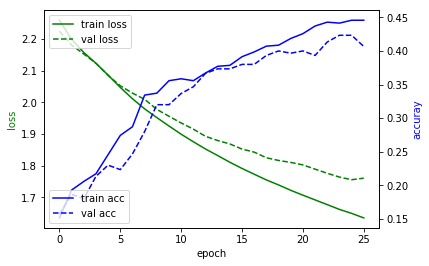

In [11]:
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
import numpy as np

np.random.seed(3)

# 1. 데이터셋 준비하기
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0

train_rand_idxs = np.random.choice(60000, 700)
X_train = X_train[train_rand_idxs]
Y_train = Y_train[train_rand_idxs]

X_test = X_test.reshape(10000, 784).astype('float32') / 255.0

test_rand_idxs = np.random.choice(10000, 300)
X_test = X_test[test_rand_idxs]
Y_test = Y_test[test_rand_idxs]

Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(units=2, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# 3. 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
early_stopping = EarlyStopping() # 조기종료 콜백함수 정의
hist = model.fit(X_train, Y_train, epochs=1000, batch_size=10, validation_data=(X_test, Y_test), callbacks=[early_stopping])

In [ ]:

# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'g', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g--', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'b--', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss', color='g')
acc_ax.set_ylabel('accuray', color='b')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

![img](http://tykimos.github.com/Keras/warehouse/2017-7-9-Early_Stopping_2.png)

In [9]:
# 6. 모델 사용하기
loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=32)

print('')
print('loss_and_metrics : ' + str(loss_and_metrics))

 32/300 [==>...........................] - ETA: 0s
loss_and_metrics : [1.760471485455831, 0.40666666666666668]


val_loss 값이 감소되다가 증가되자마자 학습이 종료되었습니다. 하지만 이 모델은 좀 더 학습이 될 수 있는 모델임을 이미 알고 있습니다. val_loss 특성 상 증가/감소를 반복하므로 val_loss가 증가되는 시점에 바로 종료하지말고 지속적으로 증가되는 시점에서 종료해보겠습니다. 이를 위해 EarlyStopping 콜백함수에서 patience 인자를 사용합니다.

    early_stopping = EarlyStopping(patience = 20)
    
즉 증가가 되었더라도 20 에포크 동안은 기다려보도록 지정했습니다. 이를 적용한 코드는 다음과 같습니다.

Train on 700 samples, validate on 300 samples
Epoch 1/1000
700/700 [==============================] - 0s - loss: 2.2596 - acc: 0.1514 - val_loss: 2.2248 - val_acc: 0.1567
Epoch 2/1000
700/700 [==============================] - 0s - loss: 2.1993 - acc: 0.1929 - val_loss: 2.1812 - val_acc: 0.1867
Epoch 3/1000
700/700 [==============================] - 0s - loss: 2.1578 - acc: 0.2057 - val_loss: 2.1529 - val_acc: 0.1800
Epoch 4/1000
700/700 [==============================] - 0s - loss: 2.1236 - acc: 0.2171 - val_loss: 2.1235 - val_acc: 0.2133
Epoch 5/1000
700/700 [==============================] - 0s - loss: 2.0861 - acc: 0.2457 - val_loss: 2.0852 - val_acc: 0.2300
Epoch 6/1000
700/700 [==============================] - 0s - loss: 2.0473 - acc: 0.2743 - val_loss: 2.0525 - val_acc: 0.2233
Epoch 7/1000
700/700 [==============================] - 0s - loss: 2.0114 - acc: 0.2871 - val_loss: 2.0293 - val_acc: 0.2467
Epoch 8/1000
700/700 [==============================] - 0s - loss: 1.9795 - acc

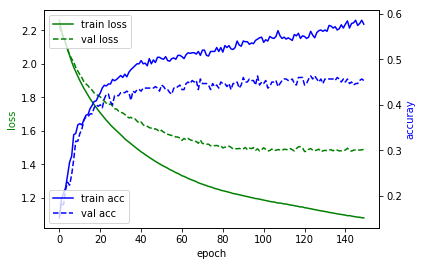

In [17]:
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
import numpy as np

np.random.seed(3)

# 1. 데이터셋 준비하기
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0

train_rand_idxs = np.random.choice(60000, 700)
X_train = X_train[train_rand_idxs]
Y_train = Y_train[train_rand_idxs]

X_test = X_test.reshape(10000, 784).astype('float32') / 255.0

test_rand_idxs = np.random.choice(10000, 300)
X_test = X_test[test_rand_idxs]
Y_test = Y_test[test_rand_idxs]

Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(units=2, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# 3. 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
early_stopping = EarlyStopping(patience = 20) # 조기종료 콜백함수 정의
hist = model.fit(X_train, Y_train, epochs=1000, batch_size=10, validation_data=(X_test, Y_test), callbacks=[early_stopping])

In [ ]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'g', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g--', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'b--', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss', color='g')
acc_ax.set_ylabel('accuray', color='b')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

![img](http://tykimos.github.com/Keras/warehouse/2017-7-9-Early_Stopping_3.png)

In [18]:
# 6. 모델 사용하기
loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=32)

print('')
print('loss_and_metrics : ' + str(loss_and_metrics))

 32/300 [==>...........................] - ETA: 0s
loss_and_metrics : [1.4880069160461427, 0.45333333293596906]


모델의 정확도도 향상됨을 확인할 수 있습니다.

---

### 결론

본 절에서는 과적합되는 모델을 만들어보고, 조기종료 시키는 방법에 대해서 알아보았습니다. 케라스에서는 EarlyStopping이라는 콜백함수로 간단하게 적용해볼 수 있습니다.

![img](http://tykimos.github.com/Keras/warehouse/2017-7-9-Early_Stopping_4.png)

추가 작성.. 중간 중간 모델 값을 저장한 후 선택하기


---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/lecture/)